# Stock Price Prediction - LSTM

## 1. Importing Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [24]:
# Fix random seed for reproducibility
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

## 2. Data Collection

In [25]:
# Import historical stock price data for Apple from 2015 to 2019

# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2015-01-02'
end_date = '2019-12-31'

# Retrieve historical stock data
apple_stock_data = yf.download(ticker, start=start_date, end=end_date)

# Convert the index to a datetime format
apple_stock_data.index = pd.to_datetime(apple_stock_data.index)

# Display the data
apple_stock_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687304,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021715,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944683,237458000
...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908966,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342964,93121200


In [26]:
apple_stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [27]:
daily_sentiment = pd.read_csv('AAPL_Tweets_with_Sentiment.csv')
daily_sentiment

,post_date,sentiment_score
0,2015-01-01,0.143239
1,2015-01-02,0.104553
2,2015-01-03,0.241900
3,2015-01-04,0.221991
4,2015-01-05,0.146851
...,...,...
1821,2019-12-27,0.197678
1822,2019-12-28,0.178845
1823,2019-12-29,0.194674
1824,2019-12-30,0.222292


## 3. Data Preprocessing

In [28]:
# Check for missing values in the dataset
missing_data = apple_stock_data.isnull().sum()
print("Missing data before reindexing:\n", missing_data)

Missing data before reindexing:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [29]:
# Apply linear interpolation to fill missing values (if any)

# Create a full date range for the given period (including weekends/holidays)
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
apple_stock_data_full = apple_stock_data.reindex(full_date_range)

# Interpolate the missing data using linear method
apple_stock_data_interpolated = apple_stock_data_full.interpolate(method='linear')
apple_stock_data_cleaned = apple_stock_data_interpolated.dropna()

# Check for any remaining missing data
missing_data_after = apple_stock_data_cleaned.isnull().sum()
print("Missing data after preprocessing:\n", missing_data_after)

# Display the cleaned data and check the first 15 rows
print("Cleaned data after interpolation and dropping NaNs:\n")
apple_stock_data_cleaned.head()

Missing data after preprocessing:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Cleaned data after interpolation and dropping NaNs:



,Open,High,Low,Close,Adj Close,Volume
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,2.128184e+08
2015-01-03,27.589167,27.627501,26.675833,27.075834,24.145075,2.275929e+08
2015-01-04,27.330833,27.395000,26.514167,26.819167,23.916189,2.423675e+08
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687304,2.571420e+08
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,2.631884e+08


In [30]:
apple_stock_data_cleaned = apple_stock_data_cleaned.reset_index()

# Rename the column to 'Date' if yfinance didn't set a proper header
apple_stock_data_cleaned.rename(columns={'index': 'Date'}, inplace=True)
apple_stock_data_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,2.128184e+08
1,2015-01-03,27.589167,27.627501,26.675833,27.075834,24.145075,2.275929e+08
2,2015-01-04,27.330833,27.395000,26.514167,26.819167,23.916189,2.423675e+08
3,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687304,2.571420e+08
4,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,2.631884e+08
...,...,...,...,...,...,...,...
1820,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.316284,1.462660e+08
1821,2019-12-28,72.641665,73.385834,71.788333,72.593330,70.455391,1.455488e+08
1822,2019-12-29,72.503332,73.279167,71.546666,72.736664,70.594498,1.448316e+08
1823,2019-12-30,72.364998,73.172501,71.305000,72.879997,70.733604,1.441144e+08


In [31]:
daily_sentiment['post_date'] = pd.to_datetime(daily_sentiment['post_date']).dt.date
daily_sentiment

,post_date,sentiment_score
0,2015-01-01,0.143239
1,2015-01-02,0.104553
2,2015-01-03,0.241900
3,2015-01-04,0.221991
4,2015-01-05,0.146851
...,...,...
1821,2019-12-27,0.197678
1822,2019-12-28,0.178845
1823,2019-12-29,0.194674
1824,2019-12-30,0.222292


After applying linear interpolation, the missing values were successfully filled, resulting in a clean dataset with no further missing data. This step ensures the continuity of the time series data, which is crucial for accurate stock price prediction.

In [32]:
# Create a Combined dataset with daily Adj Close price and sentiment score
apple_stock_data_cleaned['Date'] = pd.to_datetime(apple_stock_data_cleaned['Date']).dt.date
daily_sentiment['post_date'] = pd.to_datetime(daily_sentiment['post_date']).dt.date
merged_df = pd.merge(apple_stock_data_cleaned, daily_sentiment, left_on='Date', right_on='post_date', how='left')
merged_df = merged_df[['Date', 'Adj Close', 'sentiment_score']]
merged_df

,Date,Adj Close,sentiment_score
0,2015-01-02,24.373960,0.104553
1,2015-01-03,24.145075,0.241900
2,2015-01-04,23.916189,0.221991
3,2015-01-05,23.687304,0.146851
4,2015-01-06,23.689537,0.163620
...,...,...,...
1820,2019-12-27,70.316284,0.197678
1821,2019-12-28,70.455391,0.178845
1822,2019-12-29,70.594498,0.194674
1823,2019-12-30,70.733604,0.222292


## 4. Data Visualization

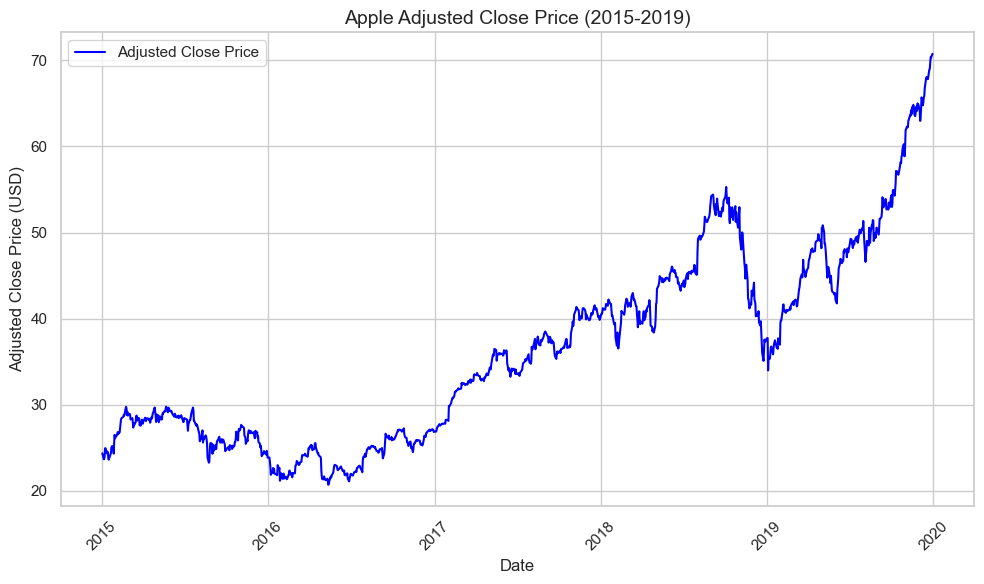

In [33]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plot the adjusted close price over time
plt.figure(figsize=(10, 6))
plt.plot(apple_stock_data.index, apple_stock_data['Adj Close'], color='blue', label='Adjusted Close Price')
plt.title('Apple Adjusted Close Price (2015-2019)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


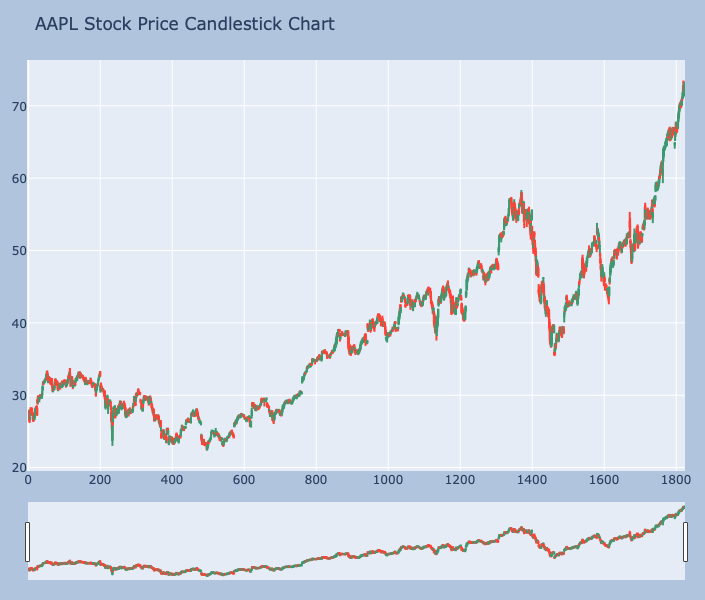

In [34]:
# Use the cleaned data DataFrame
temp_df = apple_stock_data_cleaned.copy()

# Create the candlestick chart
fig = go.Figure(
    data=[
        go.Candlestick(
            x=temp_df.index,
            open=temp_df["Open"],
            high=temp_df["High"],
            low=temp_df["Low"],
            close=temp_df["Close"],
        )
    ]
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    height=600,  # Adjust the height as needed
    paper_bgcolor="LightSteelBlue",
    title="AAPL Stock Price Candlestick Chart",
)

# Show the chart
fig.show()


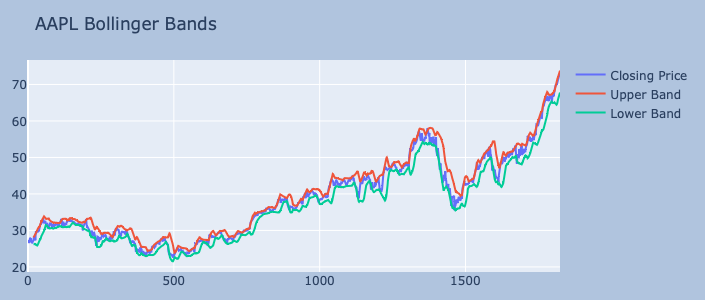

In [35]:
temp_df['SMA_20'] = temp_df['Close'].rolling(window=20).mean()
temp_df['STD_20'] = temp_df['Close'].rolling(window=20).std()
temp_df['Upper Band'] = temp_df['SMA_20'] + (temp_df['STD_20'] * 2)
temp_df['Lower Band'] = temp_df['SMA_20'] - (temp_df['STD_20'] * 2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Upper Band'], mode='lines', name='Upper Band'))
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Lower Band'], mode='lines', name='Lower Band'))

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    height=300,
    paper_bgcolor="LightSteelBlue",
    title="AAPL Bollinger Bands"
)

fig.show()


Bollinger Bands are used to identify volatility of the stock prices. It shows if a stock was potentially overbought or oversold  by showing how price moves relative to its moving average. When the price moves outside the bands, it indicates a potential reversal or continuation in the trend.

- For AAPL however, this seems pretty stable

## 5. LSTM Model Build

In [36]:
# Determine the split indices
total_length = len(merged_df)
train_end = round(0.7 * total_length)
val_end = train_end + round(0.15 * total_length)

# Split the data
train_data = merged_df[:train_end].iloc[:,1:3]
val_data = merged_df[train_end:val_end].iloc[:,1:3]
test_data = merged_df[val_end:].iloc[:,1:3]

# Display the sizes of each dataset
print(f"Training set size (70%): {len(train_data)}")
print(f"Validation set size (15%): {len(val_data)}")
print(f"Test set size (15%): {len(test_data)}")

Training set size (70%): 1278
Validation set size (15%): 274
Test set size (15%): 273


In [37]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler on the training data and transform it
train_data_scaled = scaler.fit_transform(train_data[['Adj Close', 'sentiment_score']])

# Transform the validation and test data using the same scaler
val_data_scaled = scaler.transform(val_data[['Adj Close', 'sentiment_score']])
test_data_scaled = scaler.transform(test_data[['Adj Close', 'sentiment_score']])

# Display the first few rows of the scaled datasets
print("Scaled Training data:\n", train_data_scaled[:5])
print("Scaled Validation data:\n", val_data_scaled[:5])
print("Scaled Test data:\n", test_data_scaled[:5])

Scaled Training data:
 [[0.14426821 0.25639003]
 [0.1352311  0.4893197 ]
 [0.12619399 0.45555562]
 [0.11715688 0.32812394]
 [0.11724506 0.35656283]]
Scaled Validation data:
 [[0.90571183 0.5646189 ]
 [0.91264777 0.55246169]
 [0.91958371 0.46787679]
 [0.94367097 0.58126425]
 [0.95182512 0.6926518 ]]
Scaled Test data:
 [[1.03358029 0.60924549]
 [1.03680302 0.64613505]
 [1.0492204  0.62756683]
 [1.05901516 0.76843545]
 [1.06880992 0.78939042]]


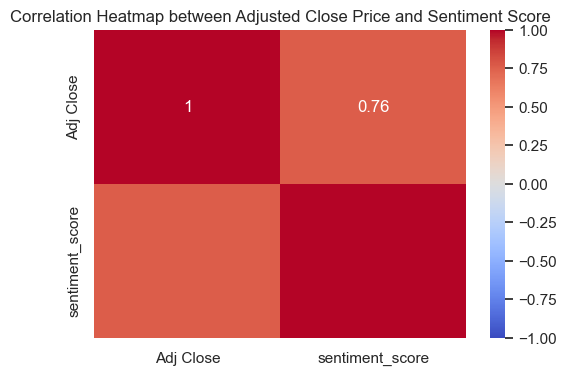

In [38]:
# Calculate correlation between scaled adjusted close price and sentiment score
train_df = pd.DataFrame(train_data_scaled, columns = ['Adj Close', 'sentiment_score'])
correlation = train_df.corr()
# Plot heatmap for correlation
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Adjusted Close Price and Sentiment Score')
plt.show()


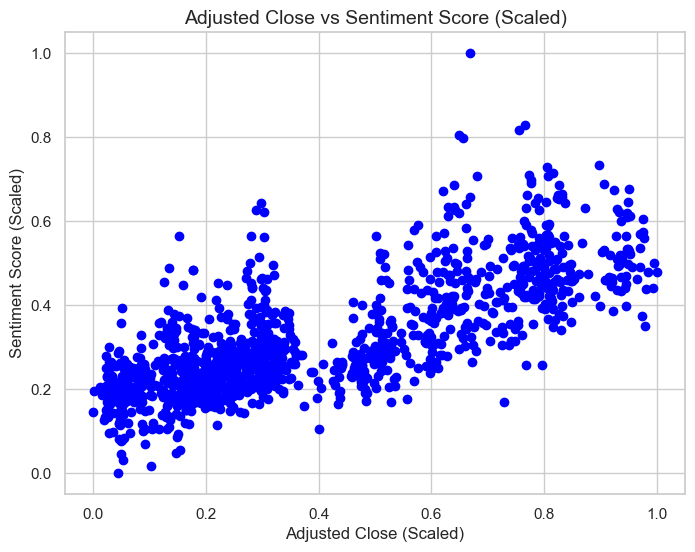

In [39]:
# Split the two columns (features)
adjusted_close_scaled = train_data_scaled[:, 0]  # First column (Adjusted Close)
sentiment_score_scaled = train_data_scaled[:, 1]  # Second column (Sentiment Score)

# Create a scatter plot of Adjusted Close vs Sentiment Score
plt.figure(figsize=(8, 6))
plt.scatter(adjusted_close_scaled, sentiment_score_scaled, color='blue')
plt.title('Adjusted Close vs Sentiment Score (Scaled)', fontsize=14)
plt.xlabel('Adjusted Close (Scaled)', fontsize=12)
plt.ylabel('Sentiment Score (Scaled)', fontsize=12)
plt.grid(True)
plt.show()

In [40]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Store the sequence for all features
        X.append(data[i:i + sequence_length])
        # The target first feature (Adjusted Close) is the next time step
        y.append(data[i + sequence_length, 0]) 
    return np.array(X), np.array(y)

# Define the sequence length
sequence_length = 30  # Number of time steps in each sequence

# Assuming train_data_scaled, val_data_scaled, and test_data_scaled 
# are NumPy arrays with multiple features (e.g., Adjusted Close and Sentiment Score)

# Create sequences for training, validation, and test sets
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Display the shapes of the created sequences
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1248, 30, 2)
y_train shape: (1248,)
X_val shape: (244, 30, 2)
y_val shape: (244,)
X_test shape: (243, 30, 2)
y_test shape: (243,)


In [41]:
# Define the LSTM model
def create_lstm_model(input_shape, num_of_units, dropout_ratio, summary):
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(X_train.shape[1], 2)))
    lstm_model.add(LSTM(num_of_units, return_sequences= True, input_shape=input_shape))
    lstm_model.add(Dropout(dropout_ratio))
    lstm_model.add(LSTM(num_of_units, return_sequences= True))
    lstm_model.add(Dropout(dropout_ratio))
    lstm_model.add(LSTM(num_of_units, return_sequences= False))
    lstm_model.add(Dropout(dropout_ratio))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer = "adam", loss = "mean_squared_error")
    if summary==True:
        lstm_model.summary()
    return lstm_model

# Define input shape
input_shape = (X_train.shape[1], 2)  # (sequence_length, number of features)
# print(input_shape)

In [42]:
# Train the LSTM model with early stopping
def train_lstm_model(model, batch_size, epochs, verbose):
    # Set up early stopping to monitor validation loss and restore best weights
    # patience (int) – Number of events to wait if no improvement and then stop the training.
    # verbose displays messages when the callback takes an action
    early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        epochs=200, 
        batch_size=batch_size, 
        callbacks=[early_stop],
        verbose=verbose
    )
    return history

In [43]:
# Plot learning curve function
def plot_learning_curve(history, batch_size, ax=None):  # Uniform scale
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
    ax.plot(train_loss, label=f'Train Loss (Batch Size: {batch_size})')
    ax.plot(val_loss, label=f'Val Loss (Batch Size: {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    # ax.set_ylim(ylim)  # Set same y-axis limits for all plots

/Users/anushaagarwal/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model trained for 100 number of units and 16 batch size
Model trained for 100 number of units and 32 batch size
Model trained for 100 number of units and 64 batch size
Model trained for 100 number of units and 128 batch size
Model trained for 200 number of units and 16 batch size
Model trained for 200 number of units and 32 batch size
Model trained for 200 number of units and 64 batch size
Model trained for 200 number of units and 128 batch size
Model trained for 300 number of units and 16 batch size
Model trained for 300 number of units and 32 batch size
Model trained for 300 number of units and 64 batch size
Model trained for 300 number of units and 128 batch size


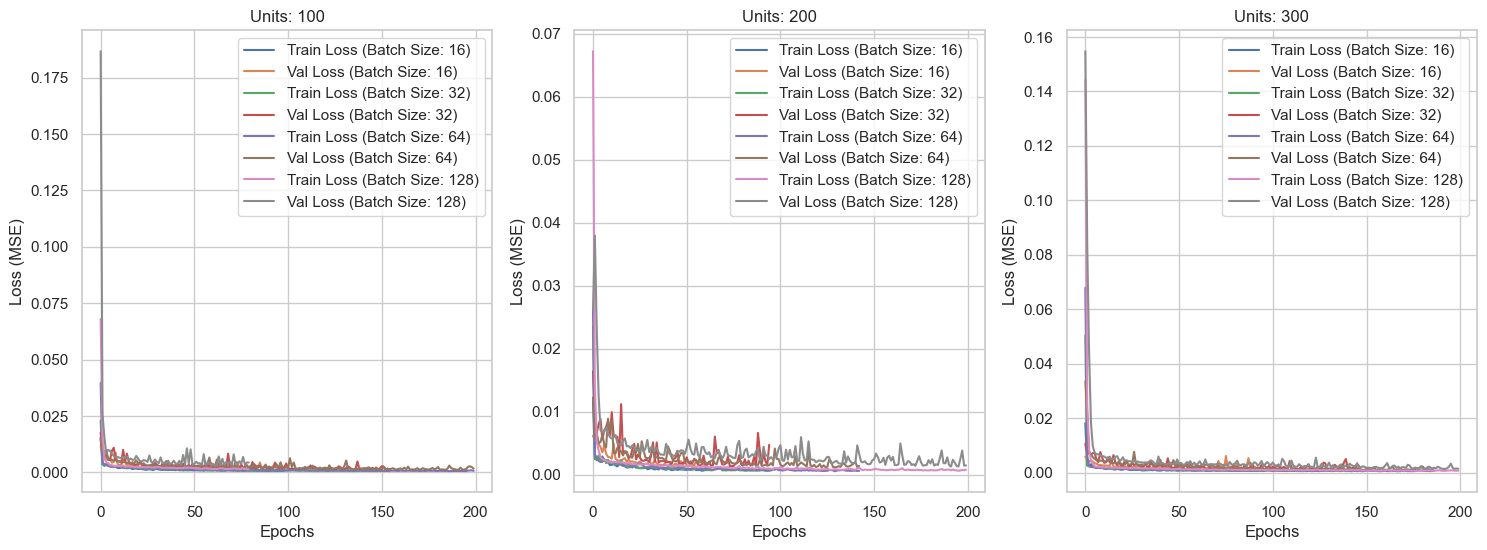

Best combinations based on Avg Validation Loss and Gap:


,Units,Batch Size,Avg Train Loss,Avg Val Loss,Gap
0,300,64,0.000576,0.001311,0.000735
1,300,32,0.000555,0.001492,0.000937
2,200,64,0.000649,0.001614,0.000964
3,200,16,0.000752,0.001758,0.001006
4,300,128,0.000715,0.001838,0.001122
5,100,32,0.000679,0.001945,0.001267
6,300,16,0.000654,0.002012,0.001358
7,200,128,0.000737,0.002141,0.001403
8,100,64,0.000824,0.002187,0.001363
9,100,16,0.000703,0.002206,0.001503


In [44]:
# Different batch sizes to try
batch_sizes = [16, 32, 64, 128]
units_list = [100, 200, 300]

# To store results for each combination
results = []

# Set a common y-axis scale for the plots
# common_ylim = (0, 0.07)
# Plot for each units value (3 graphs, 1 for each units value)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for i, units in enumerate(units_list):
    ax = axes[i]
    for batch_size in batch_sizes:
        model = create_lstm_model(input_shape, num_of_units=units, dropout_ratio=0.2, summary=False)
        history = train_lstm_model(model=model, batch_size=batch_size, epochs=200,verbose=0)
        # Plot learning curve
        plot_learning_curve(history, batch_size, ax=ax)

        # Calculate the average loss for training and validation (last 5 epochs)
        avg_train_loss = np.mean(history.history['loss'][-5:])
        avg_val_loss = np.mean(history.history['val_loss'][-5:])
        gap = avg_val_loss - avg_train_loss
        print(f"Model trained for {units} number of units and {batch_size} batch size")
        # Store results: (units, batch_size, avg_train_loss, avg_val_loss, gap)
        results.append((units, batch_size, avg_train_loss, avg_val_loss, gap))
    
    ax.set_title(f'Units: {units}')

plt.show()

# Analyzing the best combination based on minimal loss and gap
results_df = pd.DataFrame(results, columns=['Units', 'Batch Size', 'Avg Train Loss', 'Avg Val Loss', 'Gap'])
results_df_sorted = results_df.sort_values(by=['Avg Val Loss', 'Gap'])
results_df_sorted = results_df_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print("Best combinations based on Avg Validation Loss and Gap:")
results_df_sorted

In [45]:
print(results)

[(100, 16, 0.0007033459027297795, 0.002206418686546385, 0.0015030727838166056), (100, 32, 0.0006785263074561953, 0.0019453475950285792, 0.0012668212875723839), (100, 64, 0.0008241016766987741, 0.0021868190728127957, 0.0013627173961140216), (100, 128, 0.001601369958370924, 0.0045822820160537955, 0.0029809120576828716), (200, 16, 0.0007522772182710468, 0.0017584583954885602, 0.0010061811772175133), (200, 32, 0.000695930584333837, 0.0027276205131784082, 0.0020316899288445713), (200, 64, 0.0006494345725513995, 0.0016138174338266253, 0.0009643828612752258), (200, 128, 0.0007371798274107277, 0.002140535181388259, 0.001403355353977531), (300, 16, 0.0006536139990203083, 0.002011527051217854, 0.0013579130521975459), (300, 32, 0.0005546326749026776, 0.0014920411398634315, 0.000937408464960754), (300, 64, 0.00057584373280406, 0.0013112613582052291, 0.0007354176254011691), (300, 128, 0.0007154134917072951, 0.0018376470310613514, 0.0011222335393540563)]


In [46]:
# Create the LSTM model
model = create_lstm_model(input_shape, num_of_units=300, dropout_ratio=0.2, summary=True)


/Users/anushaagarwal/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 30, 300)        │       363,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 30, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 30, 300)        │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 30, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,301 (6.89 MB)

 Trainable params: 1,806,301 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = train_lstm_model(model=model, batch_size=64, epochs=200,verbose=1)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 0.1308 - val_loss: 0.0486
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0076 - val_loss: 0.0168
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0027 - val_loss: 0.0067
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3

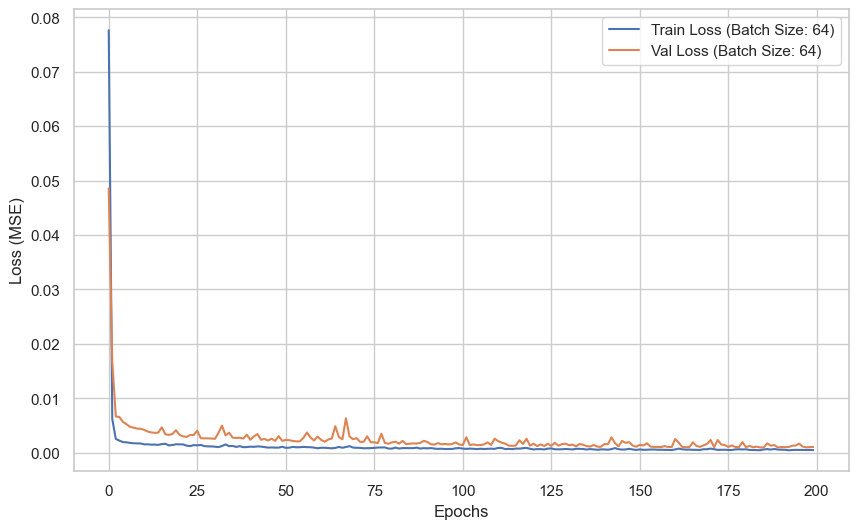

In [48]:
plot_learning_curve(history, batch_size=64, ax=None)

Above graph suggests that there is no significant overfitting done on the training dataset

In [49]:
# Make predictions using the trained LSTM model
predictions_train = model.predict(X_train)
predictions_valid = model.predict(X_val)
predictions_test = model.predict(X_test)

# # Rescale predictions and actual values back to their original scale
# predictions_train_original = scaler.inverse_transform(predictions_train)
# predictions_valid_original = scaler.inverse_transform(predictions_valid)
# predictions_test_original = scaler.inverse_transform(predictions_test)

# actual_train_original = scaler.inverse_transform(y_train)
# actual_valid_original = scaler.inverse_transform(y_val)
# actual_test_original = scaler.inverse_transform(y_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [50]:
# Since the predictions are only for the Adjusted Close, we need to inverse transform 
# but only for the first feature (which is Adjusted Close)

# Rescale the predictions back to the original scale
# Prepare an array for inverse transformation with shape matching the scaler's expected input
# We need to fill other feature columns with zeros (or any placeholder) since we're focusing on just one feature

# Inverse transform predictions
def inverse_transform_single_feature(predictions, scaler, num_features=2):
    # Create an empty array with the same number of rows as predictions and columns matching num_features
    temp_array = np.zeros((predictions.shape[0], num_features))
    
    # Put the predicted values into the first column (for Adjusted Close)
    temp_array[:, 0] = predictions[:, 0]  # Assumes predictions is 2D (samples, 1)
    
    # Inverse transform using the scaler
    return scaler.inverse_transform(temp_array)[:, 0]  # Only return the first column (Adjusted Close)

# Rescale predictions for train, validation, and test sets
predictions_train_original = inverse_transform_single_feature(predictions_train, scaler)
predictions_valid_original = inverse_transform_single_feature(predictions_valid, scaler)
predictions_test_original = inverse_transform_single_feature(predictions_test, scaler)

# Rescale the actual values (y_train, y_val, y_test)
# Reshaping y_train, y_val, y_test before inverse transforming
y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

actual_train_original = inverse_transform_single_feature(y_train_reshaped, scaler)
actual_valid_original = inverse_transform_single_feature(y_val_reshaped, scaler)
actual_test_original = inverse_transform_single_feature(y_test_reshaped, scaler)

# Display the results (you can replace print with plotting or further analysis)
print("Train Predictions (Original Scale):", predictions_train_original[:5])
print("Train Actual (Original Scale):", actual_train_original[:5])


Train Predictions (Original Scale): [26.40468552 26.4359725  26.4491236  26.48039246 26.6196765 ]
Train Actual (Original Scale): [26.33805593 26.44729424 26.45175171 26.65462494 26.84486961]


In [51]:
# Display the first few values to verify
print("Predictions on training data:\n", predictions_train_original[:5])
print("Actual training data labels:\n", actual_train_original[:5])
print("Predictions on validation data:\n", predictions_valid_original[:5])
print("Actual validation data labels:\n", actual_valid_original[:5])
print("Predictions on test data:\n", predictions_test_original[:5])
print("Actual test data labels:\n", actual_test_original[:5])

Predictions on training data:
 [26.40468552 26.4359725  26.4491236  26.48039246 26.6196765 ]
Actual training data labels:
 [26.33805593 26.44729424 26.45175171 26.65462494 26.84486961]
Predictions on validation data:
 [47.28899187 48.85665894 49.28854755 49.41905766 49.48066545]
Actual validation data labels:
 [49.23064041 49.37306976 49.45852788 49.543986   49.62944412]
Predictions on test data:
 [50.09200018 50.60873274 50.53977911 50.38234032 50.15809458]
Actual test data labels:
 [50.8350029  50.57332484 50.31164678 50.04996872 48.70077133]


## 6. Performance Evaluation

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Calculate performance metrics
mse_train = mean_squared_error(actual_train_original, predictions_train_original)
mse_valid = mean_squared_error(actual_valid_original, predictions_valid_original)
mse_test = mean_squared_error(actual_test_original, predictions_test_original)

mape_train = mean_absolute_percentage_error(actual_train_original, predictions_train_original)
mape_valid = mean_absolute_percentage_error(actual_valid_original, predictions_valid_original)
mape_test = mean_absolute_percentage_error(actual_test_original, predictions_test_original)

r2_train = r2_score(actual_train_original, predictions_train_original)
r2_valid = r2_score(actual_valid_original, predictions_valid_original)
r2_test = r2_score(actual_test_original, predictions_test_original)

# Create a DataFrame for better readability
import pandas as pd

performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'MAPE', 'R²'],
    'Training': [mse_train, mape_train, r2_train],
    'Validation': [mse_valid, mape_valid, r2_valid],
    'Test': [mse_test, mape_test, r2_test]
})

print(performance_metrics)


  Metric  Training  Validation      Test
0    MSE  0.154271    0.622456  1.597258
1   MAPE  0.008848    0.012473  0.016400
2     R²  0.996706    0.983048  0.973073


As expected, the best performance (lowest MSE, and highesr R2) is for the Training set, followed by performance of Validation and Test Set

In [65]:
# Create a function to plot predictions vs. actual values with dates and shift for sequence length
def plot_predictions_vs_actual(actual, predicted, title, dates, sequence_length, color_actual='blue', color_predicted='red'):
    plt.figure(figsize=(8, 4))
    
    # Adjust dates to account for the sequence length (shifting by sequence length)
    shifted_dates = dates[sequence_length:]
    
    # Plot actual and predicted values with corresponding shifted dates
    plt.plot(shifted_dates, actual, label='Actual', color=color_actual, linestyle='-', marker='o', markersize=3)
    plt.plot(shifted_dates, predicted, label='Predicted', color=color_predicted, linestyle='--', marker='x', markersize=3)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Set sequence length
sequence_length = 30

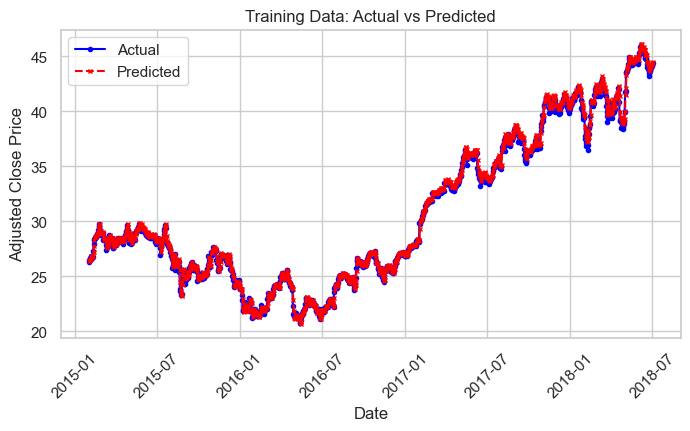

In [66]:
# Plot for Training Data
plot_predictions_vs_actual(actual_train_original, 
                           predictions_train_original, 
                           'Training Data: Actual vs Predicted', 
                           merged_df['Date'][:train_end], 
                           sequence_length
                          )

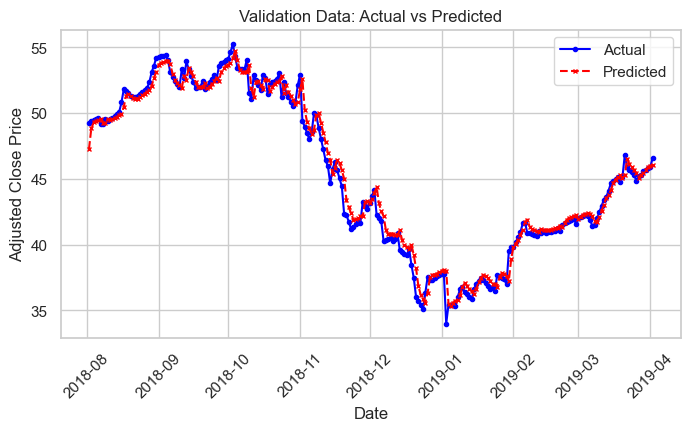

In [67]:
# Plot for Validation Data
plot_predictions_vs_actual(actual_valid_original, 
                           predictions_valid_original, 
                           'Validation Data: Actual vs Predicted', 
                           merged_df['Date'][train_end:val_end], 
                           sequence_length
                          )

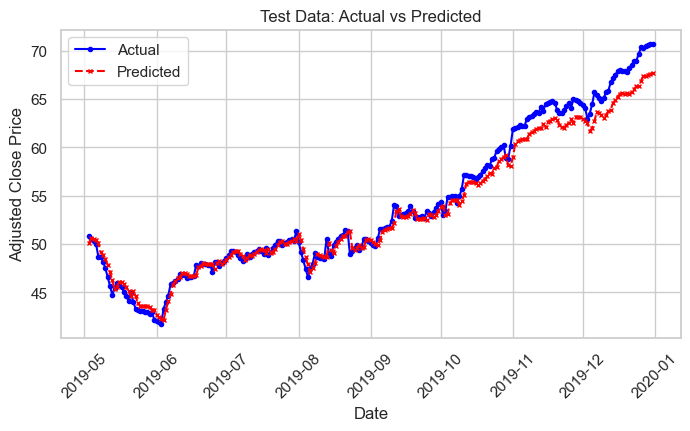

In [68]:
# Plot for Test Data
plot_predictions_vs_actual(actual_test_original, 
                           predictions_test_original, 
                           'Test Data: Actual vs Predicted', 
                           merged_df['Date'][val_end:], 
                           sequence_length
                          )

In [72]:
# Create a DataFrame function with shifted dates
def create_dataframe(dates, actual, predicted, sequence_length):
    # Shift dates by the sequence length to align with predictions
    shifted_dates = dates[sequence_length:]
    return pd.DataFrame({
        'Date': shifted_dates,
        'Actual': actual.flatten(),
        'Predicted': predicted.flatten()
    })

# Plot function for predictions vs actual
def plot_predictions_vs_actual(dates, actual, predicted, label_actual, label_predicted, color_actual, color_predicted):
    plt.plot(dates, actual, label=label_actual, color=color_actual, linestyle='-', marker='o', markersize=3)
    plt.plot(dates, predicted, label=label_predicted, color=color_predicted, linestyle='--', marker='x', markersize=2)


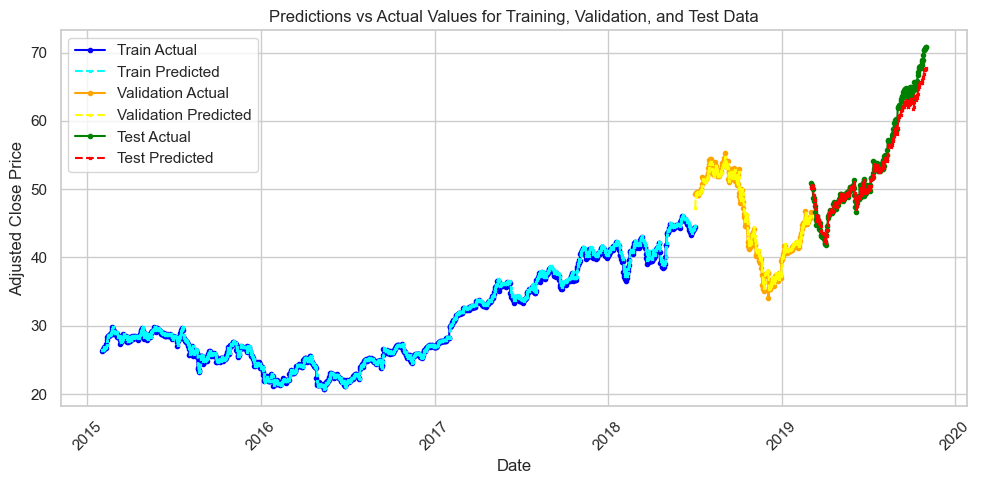

In [73]:
# Define sequence length
sequence_length = 30

# Ensure indices are aligned with the original dates for each dataset and shift by sequence length
dates_train = apple_stock_data_cleaned['Date'][:len(actual_train_original) + sequence_length]
dates_valid = apple_stock_data_cleaned['Date'][len(actual_train_original):len(actual_train_original) + len(actual_valid_original) + sequence_length]
dates_test = apple_stock_data_cleaned['Date'][len(actual_train_original) + len(actual_valid_original):len(actual_train_original) + len(actual_valid_original) + len(actual_test_original) + sequence_length]

# Create DataFrames for plotting with shifted dates
df_train = create_dataframe(dates_train, actual_train_original, predictions_train_original, sequence_length)
df_valid = create_dataframe(dates_valid, actual_valid_original, predictions_valid_original, sequence_length)
df_test = create_dataframe(dates_test, actual_test_original, predictions_test_original, sequence_length)

# Plot the combined data
plt.figure(figsize=(10, 5))

# Plot training data
plot_predictions_vs_actual(df_train['Date'], df_train['Actual'], df_train['Predicted'], 'Train Actual', 'Train Predicted', 'blue', 'cyan')
plot_predictions_vs_actual(df_valid['Date'], df_valid['Actual'], df_valid['Predicted'], 'Validation Actual', 'Validation Predicted', 'orange', 'yellow')
plot_predictions_vs_actual(df_test['Date'], df_test['Actual'], df_test['Predicted'], 'Test Actual', 'Test Predicted', 'green', 'red')

# Formatting the plot
plt.title('Predictions vs Actual Values for Training, Validation, and Test Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
